***This Project for Product Image Classifier***

# *Import*

In [9]:
import numpy as np
import pandas as pd
import cv2 as cv
import tensorflow as tf
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
import matplotlib.pyplot as plt
from keras.utils import plot_model
from zipfile import ZipFile
from google.colab import drive
import glob as gb

# Read data

In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with ZipFile ('drive/MyDrive/task.zip','r') as ZipObj:
  ZipObj.extractall('drive/MyDrive/task')

In [6]:
# This line sets the path to the training data directory
train_path='drive/MyDrive/task/task/train/'

# This line sets the path to the testing data directory
test_path='drive/MyDrive/task/task/test/'

In [4]:


# Loop through each subdirectory in the train_path directory
for folder in os.listdir(train_path):

    # Use glob to find all the .jpg files in the current subdirectory
    images = gb.glob(pathname=str(train_path + folder + '/*.jpg'))

    # Print out the number of images found in the current subdirectory
    print(f'for training data, found {len(images)} in folder {folder}')

for training data, found 147 in folder Accessories
for training data, found 116 in folder Artifacts
for training data, found 39 in folder Beauty
for training data, found 55 in folder Fashion
for training data, found 34 in folder Games
for training data, found 104 in folder Home
for training data, found 24 in folder Nutrition
for training data, found 117 in folder Stationary


In [5]:
# Loop through each subdirectory in the test_path directory
for folder in os.listdir(test_path ):

    images=gb.glob(pathname=str(test_path  + folder +'/*.jpg'))

    print(f'for test data, found {len(images)} in folder {folder}')

for test data, found 16 in folder Accessories
for test data, found 13 in folder Artifacts
for test data, found 8 in folder Beauty
for test data, found 9 in folder Fashion
for test data, found 5 in folder Games
for test data, found 11 in folder Home
for test data, found 4 in folder Nutrition
for test data, found 13 in folder Stationary


In [6]:
# This code reads in all JPEG images in each folder of the train_path directory and finds the unique shapes of the images and their corresponding counts.
#It then prints out each unique shape and its count.
#and that help us know what the inputshape that we will give it to the model.
#if we have a different size of image or not becouse we need to make all same size.
#This for train dataset.
size=[]
for folder in os.listdir(train_path):
    images=gb.glob(pathname=str(train_path + folder +'/*.jpg'))
    for img in images:
        img=plt.imread(img)
        size.append(img.shape)
pd.Series(size).value_counts()

(1200, 540, 3)    612
(1600, 720, 3)     24
dtype: int64

In [7]:
#This for test dataset.
size=[]
for folder in os.listdir(test_path):
    images=gb.glob(pathname=str(test_path + folder +'/*.jpg'))
    for img in images:
        img=plt.imread(img)
        size.append(img.shape)
pd.Series(size).value_counts()

(1200, 540, 3)    75
(1600, 720, 3)     4
dtype: int64

In [7]:
code={'Accessories':0 ,'Artifacts':1,'Beauty':2,'Fashion':3,'Games':4,'Home':5,'Nutrition':6,'Stationary':7}
def getname(n):

    for k,v in code.items():
     if v==n:
        return k

In [10]:
#read train data, and split train into (x,y)
x_train=[]
y_train=[]
for folder in os.listdir(train_path ):
    images=gb.glob(pathname=str(train_path  + folder +'/*.jpg'))
    for img in images:
        img=cv.imread(img)
        x_train.append(img)
        y_train.append(code[folder])

In [10]:
#read test data, and split test data into (x.y)
x_test=[]
y_test=[]
for folder in os.listdir(test_path ):
    images=gb.glob(pathname=str(test_path  + folder +'/*.jpg'))
    for img in images:
        img=cv.imread(img)
        x_test.append(img)
        y_test.append(code[folder])

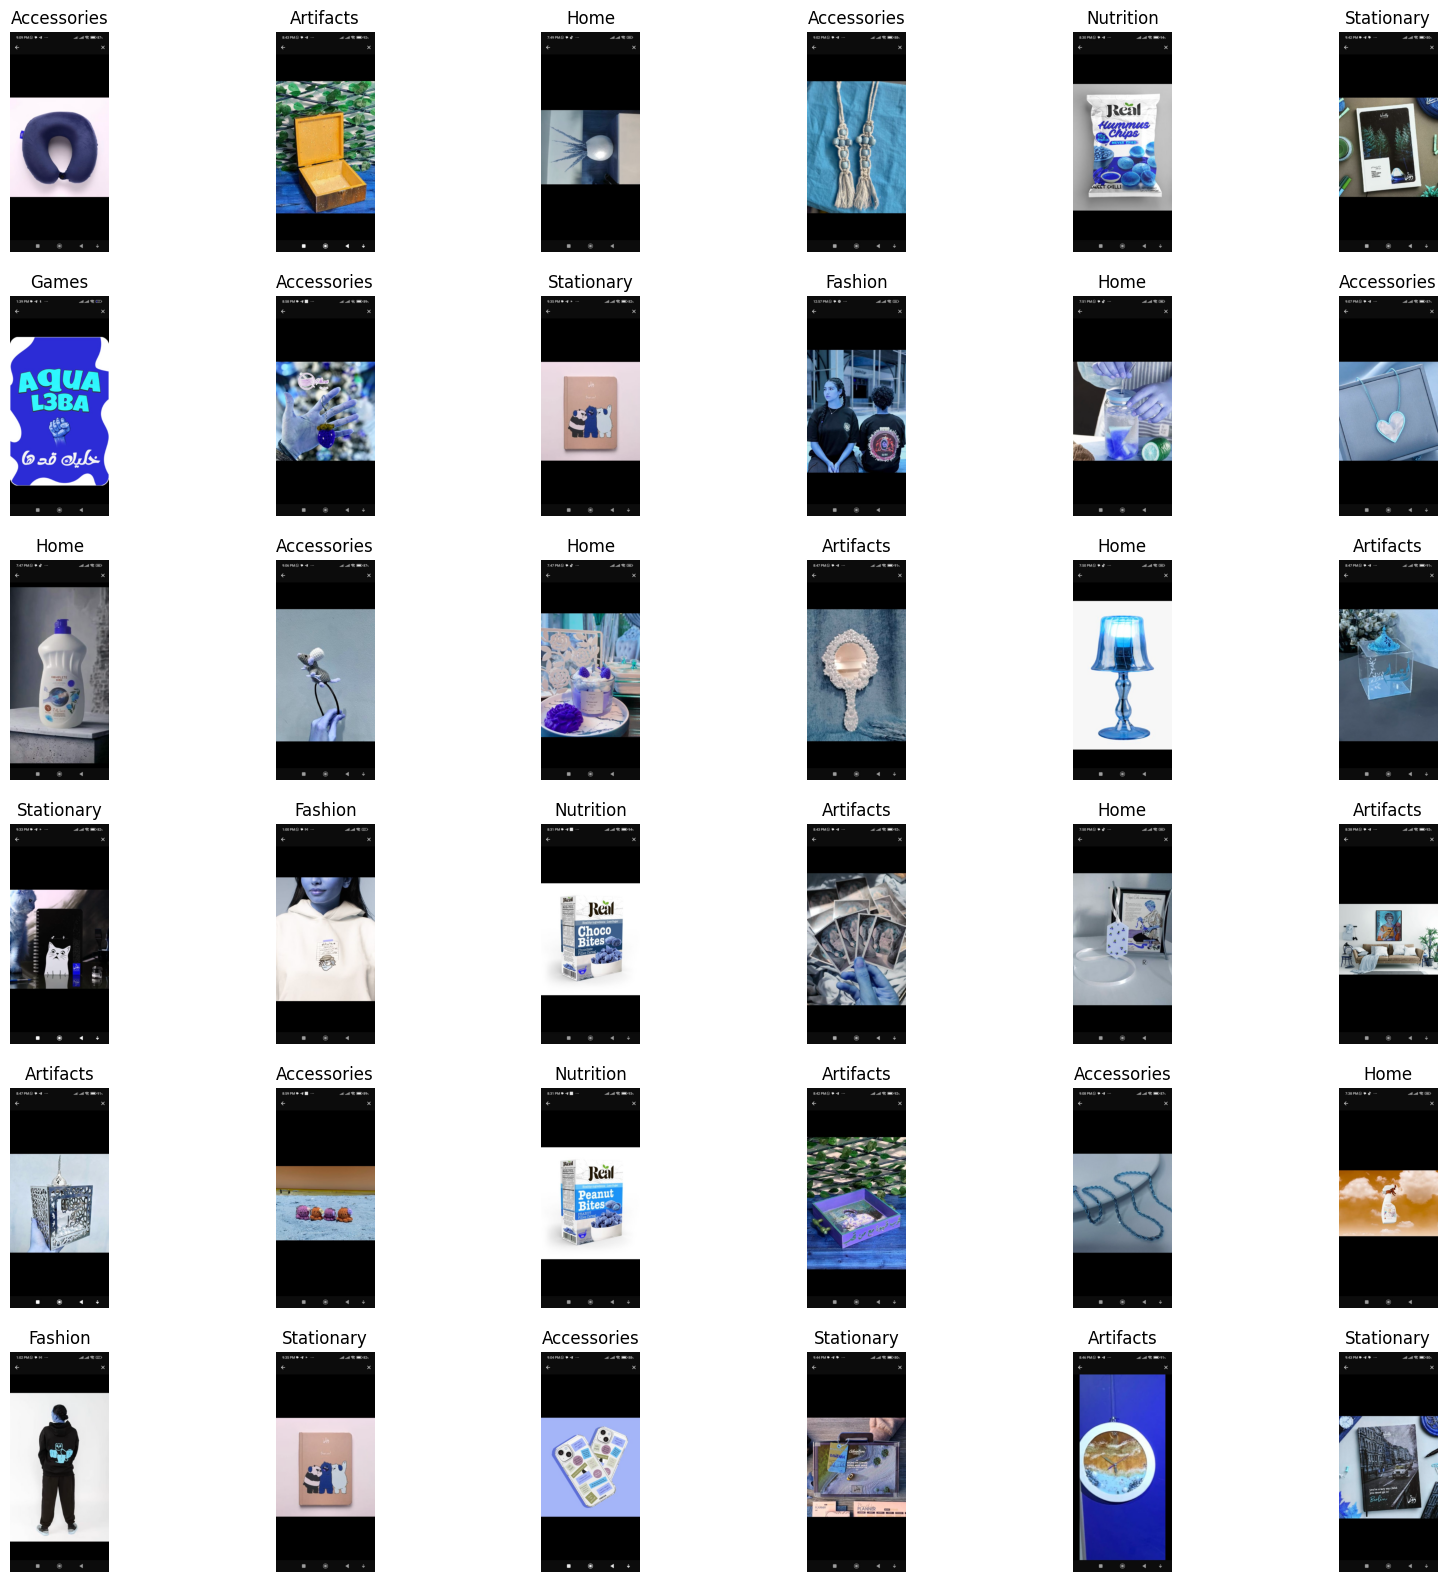

In [11]:
#visualization of a random selection of images from the x_train dataset, with their corresponding labels.
plt.figure(figsize=(20,20))
for i,v in enumerate(np.random.randint(0,len(x_train),36)):
    plt.subplot(6,6,i+1)
    plt.imshow(x_train[v])
    plt.title(getname(y_train[v]))
    plt.axis('off')

#Split Dataset

In [13]:
height,width=1600, 720
input_shape=(1600, 720, 3)
num_classes = 8
batch_size=4

In [14]:
# Load the training set from the specified directory, with a 90/10 train/validation split
train_set = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.1,   # 10% of the data will be used for validation
    subset="training",      # Use the training subset of the data
    seed=123,               # Set a random seed for reproducibility
    image_size=(height,width),  # Resize the images to the specified height and width
    batch_size=batch_size   # Set the batch size for training
)

# Load the validation set from the same directory, with the same 90/10 split
validation_set = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.1,   # 10% of the data will be used for validation
    subset="validation",    # Use the validation subset of the data
    seed=123,               # Set a random seed for reproducibility
    image_size=(height, width), # Resize the images to the specified height and width
    batch_size=batch_size   # Set the batch size for validation
)

# Load the test set from the specified directory
test_set = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    image_size=(height, width), # Resize the images to the specified height and width
    batch_size=batch_size   # Set the batch size for testing
)

Found 636 files belonging to 8 classes.
Using 573 files for training.
Found 636 files belonging to 8 classes.
Using 63 files for validation.
Found 79 files belonging to 8 classes.


# EarlyStop And Checkpoint

In [15]:
# This for sets up early stopping during training.
#'val_loss' is monitored, and training stops if it doesn't improve for 8 epochs.
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)

#This for sets up model checkpointing during training.
#'val_accuracy' is monitored, and the best model is saved to 'best_model.h5'.
#Only the best model is saved, based on validation accuracy.
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# Model Building

In [16]:
# Import the EfficientNetV2B3 model from Keras applications
imported_model = tf.keras.applications.EfficientNetV2B3(include_top=False,
                                                        input_shape=input_shape,
                                                        pooling='max',
                                                        classes=8,
                                                        weights='imagenet')

# Create a new sequential model
model = Sequential()

# Add the imported model as a layer to the new model
model.add(imported_model)

# Add a flatten layer to the new model
model.add(Flatten())

# Add a dense layer with softmax activation and L2 regularization to the new model
model.add(Dense(8, activation='softmax', kernel_regularizer=regularizers.l2(0.1)))

52606240/52606240 [==============================] - 0s 0us/step


In [17]:
# Compile the model with the following configurations:
model.compile(
    # Use the Adam optimizer with a learning rate of 0.001
    optimizer=Adam(lr=0.001),
    # Use sparse categorical crossentropy as the loss function
    loss='sparse_categorical_crossentropy',
    # Track accuracy as a metric during training and evaluation
    metrics=['accuracy']
)

In [18]:
#summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b3 (Functio  (None, 1536)              12930622  
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 8)                 12296     
                                                                 
Total params: 12942918 (49.37 MB)
Trainable params: 12833702 (48.96 MB)
Non-trainable params: 109216 (426.62 KB)
_________________________________________________________________


# Training $ Validation

In [19]:
# Train the EfficientNet model for 15 epochs using the training set and validation set,
# and use the EarlyStopping and ModelCheckpoint callbacks to stop training early
# and save the best model based on validation accuracy
history = model.fit(x = train_set,epochs = 15,validation_data = validation_set,callbacks=[es, mc])

Epoch 1/15
144/144 [==============================] - ETA: 0s - loss: 4.8089 - accuracy: 0.3194
Epoch 1: val_accuracy improved from -inf to 0.61905, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


144/144 [==============================] - 233s 1s/step - loss: 4.8089 - accuracy: 0.3194 - val_loss: 2.6114 - val_accuracy: 0.6190
Epoch 2/15
144/144 [==============================] - ETA: 0s - loss: 2.3925 - accuracy: 0.6335
Epoch 2: val_accuracy improved from 0.61905 to 0.73016, saving model to best_model.h5
144/144 [==============================] - 154s 1s/step - loss: 2.3925 - accuracy: 0.6335 - val_loss: 1.8314 - val_accuracy: 0.7302
Epoch 3/15
144/144 [==============================] - ETA: 0s - loss: 1.8942 - accuracy: 0.6981
Epoch 3: val_accuracy improved from 0.73016 to 0.85714, saving model to best_model.h5
144/144 [==============================] - 154s 1s/step - loss: 1.8942 - accuracy: 0.6981 - val_loss: 1.4226 - val_accuracy: 0.8571
Epoch 4/15
144/144 [==============================] - ETA: 0s - loss: 1.4293 - accuracy: 0.8202
Epoch 4: val_accuracy improved from 0.85714 to 0.87302, saving model to best_model.h5
144/144 [==============================] - 154s 1s/step - 

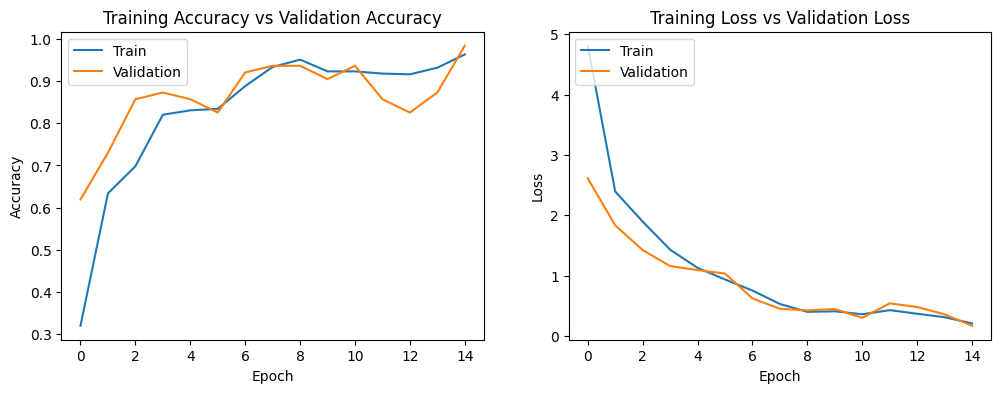

In [20]:
# Create a figure with two subplots
fig, ax = plt.subplots(1, 2)

# Get the training accuracy and loss from the history object
train_acc = history.history['accuracy']
train_loss = history.history['loss']

# Set the size of the figure
fig.set_size_inches(12, 4)

# Plot the training accuracy and validation accuracy on the first subplot
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

# Plot the training loss and validation loss on the second subplot
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

# Show the plot
plt.show()


In [21]:
# Evaluate the model on the training set and get the loss and accuracy
train_loss, train_acc = model.evaluate(train_set)

# Evaluate the model on the validation set and get the loss and accuracy
test_loss, test_acc = model.evaluate(validation_set)

# Print the final training accuracy and validation accuracy
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

16/16 [==============================] - 4s 233ms/step - loss: 0.1684 - accuracy: 0.9841
final train accuracy = 99.48 , validation accuracy = 98.41


In [22]:
# Load the saved model from the file 'best_model.h5'
model = load_model('best_model.h5')

# Testing

In [23]:
# Use the loaded model to make predictions on the test set
y_pred = model.predict(test_set)

# Convert the predicted probabilities to class labels
y_pred = np.argmax(y_pred, axis=1)

20/20 [==============================] - 9s 234ms/step


In [24]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate the model on the test set and get the loss and accuracy
test_loss, test_acc = model.evaluate(test_set)

# Print the final test accuracy
print("Final test accuracy:", test_acc)

# Convert class labels from one-hot encoding to integers for the test set
y_test_int = np.concatenate([y.numpy() for x, y in test_set], axis=0)

# Print classification report
print(classification_report(y_test_int, y_pred))

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_int, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


20/20 [==============================] - 12s 247ms/step - loss: 0.4534 - accuracy: 0.8861
Final test accuracy: 0.8860759735107422
              precision    recall  f1-score   support

           0       0.24      0.25      0.24        16
           1       0.00      0.00      0.00        13
           2       0.27      0.38      0.32         8
           3       0.12      0.11      0.12         9
           4       0.00      0.00      0.00         5
           5       0.08      0.09      0.09        11
           6       0.00      0.00      0.00         4
           7       0.15      0.15      0.15        13

    accuracy                           0.14        79
   macro avg       0.11      0.12      0.11        79
weighted avg       0.13      0.14      0.13        79

Confusion Matrix:
[[4 2 1 2 1 2 1 3]
 [2 0 2 1 0 3 1 4]
 [1 2 3 1 0 0 1 0]
 [2 1 1 1 0 3 0 1]
 [0 1 1 2 0 1 0 0]
 [4 1 1 0 1 1 1 2]
 [0 1 1 1 0 0 0 1]
 [4 4 1 0 0 2 0 2]]
